# __2.1. Filter corpus to include only relevant sentences__

Goal:
- Filter plant science corpus to include only sentences that contain entities of interests.
- USe the filtered corpus to train another plantbert

Considerations:
- The vocab size is set to be 30_522 which seems large but most technical terms will not be frequent enough to be included. Just think about gene names along, there will be more than 30k.
- Try to pre-enrich sentences that talk about the entities and terms of interests.
  - The entities and terms will include:
    - Terms in scientific dictionaries without breaking them into tokens
    - Symbol and names from TAIR, without breaking words into tokens
    - Any word in pathway annotations
    - Any word in gene ontology annotations
    - Any word in plant ontology annotations
  - Exclude 
    - Single letter workds
    - Numerical terms
    - Frequent english words
       - [Keggle english workd frequency dataset](https://www.kaggle.com/datasets/rtatman/english-word-frequency)
  - Lower case all words

Log:
- 11/27/23
  - Collect entity/term data
    - Dictionary terms: from `projects/plant_sci_hist/_vocab`
    - Pathway annotation: from [Plant Metabolic Network](https://ftp.plantcyc.org/pmn/Pathways/Data_dumps/PMN15.5_January2023/pathways/)
    - GeneOntology

## ___Setup___

In [66]:
import wget, re, spacy, gzip, shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from pathlib import Path
from tqdm import tqdm
from spacy_langdetect import LanguageDetector
from spacy.language import Language

#from urllib import request

In [67]:
proj_dir   = Path.home() / "projects/plantbert"
work_dir   = proj_dir / "2_filtered_corpus"
vocab_dir  = work_dir / "_vocab"

####
# PMN related settings
####
pmn_dir   = vocab_dir / "pmn"
annot_dir = pmn_dir / "annot"

# Did not use this directly due to issue with getting the full html
#pmn_ftp = "https://plantcyc-ftp.storage.googleapis.com/pmn/Pathways/Data_dumps/PMN15.5_January2023/pathways/"
pmn_html = pmn_dir / "PMN_Files.htm"
pmn_tag1 = "<a href=\""
pmn_tag2 = "https://plantcyc-ftp.storage.googleapis.com/"
pmn_tag3 = "\">"

# Whether to download the PMN files or not
pmn_downloaded = 1

# PMN name output files
pwy_dict_file = pmn_dir / "pmn_pathway_dict.tsv"
pro_dict_file = pmn_dir / "pmn_protein_dict.tsv"
gen_dict_file = pmn_dir / "pmn_gene_dict.tsv"

####
# TAIR related settings
####
tair_dir   = vocab_dir / "tair"
tair_gene_html = tair_dir / "tair_gene_symbol_list.html"
tair_dict_file = tair_dir / "tair_dict.tsv"

####
# Ontology related settings
####
ont_dir = vocab_dir / "ontologies"
go_file = ont_dir / "vocab_go.items"
po_file = ont_dir / "vocab_po.items"

####
# Oxford dictionary related settings
####
oxford_dir = vocab_dir / "oxford"

####
# Original and new corpus
####
dir1        = proj_dir / "1_vanilla_bert"
corpus_file = dir1 / "corpus_with_topics.tsv.gz"

###
# Kaggle word frequency
###
kaggle_dir  = work_dir / "kaggle_word_freq"
kaggle_file = kaggle_dir / "unigram_freq.csv"

###
# Merged
###
vocab_555296 = vocab_dir / "vocab_555296.txt.gz"


## ___Preprocess vocab___

### Pathway annotation

#### Process PMN html file

The PMN page indicated has weird structure and wget won't get the full page with link:
- Download full HTML via browser and go from there.


In [28]:
if pmn_downloaded == 0:
  with open(pmn_html, "r") as f:
    lines = f.readlines()
    for line in lines:
      if pmn_tag1 in line and pmn_tag2 in line:
        url = line.split(pmn_tag1)[1].split(pmn_tag3)[0]
        #print(url.split("/")[-1])
        wget.download(url, str(annot_dir))


#### Process downloaded pathway files

Get the pathway and gene names out

In [29]:
pwy_files = [f for f in annot_dir.iterdir() 
                if f.is_file() and "20230103" in f.name]

len(pwy_files)

127

In [30]:
def remove_html_tags(txt, iter):

  # find tag
  idxL    = txt.find("<")
  idxR    = txt.find(">")
  # weird situation where the tag is not closed, rid of everything after
  if idxR == -1: 
    #print("TAG NOT CLOSED")
    #print(txt)
    return txt[:idxL]
  
  tag_bgn = txt[idxL:idxR+1]
  tag_end = "</" + tag_bgn[1:]

  # remove tag
  txt = txt.replace(tag_bgn, "")
  txt = txt.replace(tag_end, "")

  if txt.find("<") != -1:
    txt = remove_html_tags(txt, iter+1)
    
  return txt

In [31]:
# Test remove_html_tags
txt = "d-<i>glucarate</i> <s><d>blah</d></s> <i>dehydrogenase</i> (NADP+)"
remove_html_tags(txt, 0)

'd-glucarate blah dehydrogenase (NADP+)'

In [32]:
def populate_dict(d, items):
  for item in items:
    # Deal with item that is unknown or nan (float)
    if item == "unknown" or type(item) == float:
      continue

    # rid of the html tags
    # e.g., D-<i>myo</i>-inositol (1,4,5)-trisphosphate biosynthesis
    original = (item + '.')[:-1]
    if item.find("<") != -1:
      item = remove_html_tags(item, 0)
      if item == -1:
        print("Original:", original)

    if item not in d:
      d[item] = 1
    else:
      d[item] += 1



In [33]:
pwy_dict = {} # {Pathway-name: count}
pro_dict = {} # {Protein-name: count}
gen_dict = {} # {Gene-name: count}
for pwy_file in tqdm(pwy_files):
  df = pd.read_csv(pwy_file, sep="\t")
  populate_dict(pwy_dict, df["Pathway-name"].unique())
  populate_dict(pro_dict, df["Protein-name"].unique())
  populate_dict(gen_dict, df["Gene-name"].unique())

len(pwy_dict), len(pro_dict), len(gen_dict)

 77%|███████▋  | 98/127 [00:00<00:00, 100.09it/s]

100%|██████████| 127/127 [00:01<00:00, 101.05it/s]


(1369, 13492, 476480)

In [34]:
# Generate output files
def generate_tsv(d, output_file):
  df = pd.DataFrame.from_dict(d, orient="index")
  df.columns = ["count"]
  df.index.name = "name"
  df = df.sort_values(by="count", ascending=False)
  df.to_csv(output_file, sep="\t", header=False)

generate_tsv(pwy_dict, pwy_dict_file)
generate_tsv(pro_dict, pro_dict_file)
generate_tsv(gen_dict, gen_dict_file)

#### Tokenize pathway terms

- Break sub-tokens with "-"
- Subtokens must be >1 characters long.
- Subtokens must not be roman numerals.
  - Check based on [this tutorial](https://dev.to/alexdjulin/a-python-regex-to-validate-roman-numerals-2g99)

In [35]:
def is_roman_number(txt):
  '''from Alexandre Donciu-Julin'''
  pattern = re.compile(r"""   
          ^M{0,3}
          (CM|CD|D?C{0,3})?
          (XC|XL|L?X{0,3})?
          (IX|IV|V?I{0,3})?$
          """, re.VERBOSE)
  
  if re.match(pattern, txt):
    return True
  return False

def tokenize(d, txt):
  tokens = txt.split(" ")
  for token in tokens:
    if "-" in token:
      sub_tokens = token.split("-")
    else:
      sub_tokens = [token]

    for sub_token in sub_tokens:
      
      # rid of paranthesis
      if sub_token == "":
        continue
      elif sub_token[0] == "(":
        sub_token = sub_token[1:]

      if sub_token == "":
        continue
      elif sub_token[-1] == ")":
        sub_token = sub_token[:-1]

      # rid of ending comma
      if sub_token == "":
        continue
      elif sub_token[-1] == ",":
        sub_token = sub_token[:-1]

      # longer than 1 characters and not a roman numeral
      if len(sub_token) > 1 and not is_roman_number(sub_token):
        if sub_token not in d:
          d[sub_token] = 1
        else:
          d[sub_token] += 1

In [36]:
pwy_token_dict = {}
for pwy in pwy_dict:
  tokenize(pwy_token_dict, pwy)


In [37]:
len(pwy_token_dict)

1299

### TAIR gene info

Table format
- 7 columns
- Symbol, Symbol Full Name, Type, Status, Reference, Contact, Submitted

Approach:
- Encounter [UnicodeDecodeError: 'utf-8' codec can't decode byte](https://www.google.com/search?client=firefox-b-1-d&q=bs4+UnicodeDecodeError%3A+%27utf-8%27+codec+can%27t+decode+byte)
- Parse table: [post (did not work)](https://stackoverflow.com/questions/23377533/python-beautifulsoup-parsing-table), [another](https://srome.github.io/Parsing-HTML-Tables-in-Python-with-BeautifulSoup-and-pandas/)
- The table is terrible.. Instead of parsing from that, copy the page as text and process it.

#### Get table using bs4

In [38]:
with open(tair_gene_html, 'r', encoding='utf-8', errors='ignore') as f:
  soup = BeautifulSoup(f.read(), 'lxml')

table = soup.find_all('table')[0]

In [39]:
type(table)

bs4.element.Tag

In [40]:
# Check out table content and format

rows = table.find_all('tr')
for ridx, row in enumerate(rows):
  cols = row.find_all('td')
  print(ridx, "num cols:", len(cols))
  for cidx, col in enumerate(cols):
    print("", cidx, [col.text])


0 num cols: 1
 0 ['\xa0']
1 num cols: 1
 0 ['']
2 num cols: 1
 0 [' Total:3275, Nov. 27, 2023 ']
3 num cols: 6
 0 ['\xa0']
 1 ['\xa0']
 2 ['\xa0']
 3 ['\xa0']
 4 ['\xa0']
 5 ['\xa0']
4 num cols: 1
 0 ['\xa0']
5 num cols: 13
 0 ['\n\n      \n      AAA \n']
 1 ['\xa0']
 2 [' \n    Activated Ac activity\xa0\n    ']
 3 ['\xa0']
 4 ['P']
 5 ['\xa0']
 6 ['OK']
 7 ['\xa0']
 8 ['\n      \n     Jarvis\n      \n      \xa0\n    ']
 9 ['\xa0']
 10 ['\n\n        Paul Jarvis  \n']
 11 ['\xa0']
 12 [' \n    1999-10-01\xa0 \n    ']
6 num cols: 13
 0 ['\n\n      \n      AAC \n']
 1 ['\xa0']
 2 [' \n    ADP/ATP Carrier 1\xa0\n    ']
 3 ['\xa0']
 4 ['G']
 5 ['\xa0']
 6 ['OK']
 7 ['\xa0']
 8 ['\n      \n      \xa0\n    ']
 9 ['\xa0']
 10 ['\n']
 11 ['\xa0']
 12 [' \n    2003-06-01\xa0 \n    ']
7 num cols: 13
 0 ['\n\n      \n      AACT \n']
 1 ['\xa0']
 2 [' \n    Anthocyanin-5-aromatic acyl transferase-like protein\xa0\n    ']
 3 ['\xa0']
 4 ['G']
 5 ['\xa0']
 6 ['OK']
 7 ['\xa0']
 8 ['\n      \n     Joh

#### Put symbols and names into a file and a dictionary

In [41]:
#new_table = pd.DataFrame(columns=range(0,7), index = [0]) # I know the size 

tair_dict = {} # {symbol or sname: count}
with open(tair_dict_file, "w") as f:
  # for each row
  for row in table.find_all('tr'):
    # get all columns
    cols = row.find_all('td')

    # skip if not 13 columns
    if len(cols) != 13:
      continue
    
    # only care about col 0 (symbol) and 2 (symbol full name)
    symbol = cols[0].get_text().strip()
    sname  = cols[2].get_text().strip()
    f.write(f"{symbol}\t{sname}\n")

    if symbol not in tair_dict:
      tair_dict[symbol] = 1
    else:
      tair_dict[symbol] += 1

    if sname not in tair_dict:
      tair_dict[sname] = 1
    else:
      tair_dict[sname] += 1

In [42]:
len(tair_dict)

6354

### Ontoloties

#### Tokenize GO terms and populate GO dictionary

In [43]:
go_items = open(go_file, "r").readlines()
go_dict = {} # {go term: count}
for item in go_items:
  item = remove_html_tags(item, 0)
  tokenize(go_dict, item)

In [44]:
len(go_dict)

23629

In [45]:
go_dict

{'mitochondrion': 231,
 'inheritance': 16,
 'mitochondrial': 1092,
 'genome': 105,
 'maintenance': 877,
 'reproduction': 64,
 'reproductive': 46,
 'physiological': 75,
 'process': 13502,
 'obsolete': 2949,
 'ribosomal': 219,
 'chaperone': 173,
 'activity': 39049,
 'high': 242,
 'affinity': 165,
 'zinc': 151,
 'transmembrane': 1620,
 'transporter': 1516,
 'uptake': 434,
 'low': 321,
 'ion': 1911,
 'thioredoxin': 55,
 'alpha': 2584,
 '1,6': 214,
 'mannosyltransferase': 110,
 'trans': 351,
 'hexaprenyltranstransferase': 1,
 'vacuole': 315,
 'single': 243,
 'strand': 263,
 'break': 157,
 'repair': 387,
 'stranded': 109,
 'DNA': 3463,
 'endodeoxyribonuclease': 91,
 'specific': 1021,
 'ssDNA': 19,
 'phosphopyruvate': 18,
 'hydratase': 128,
 'complex': 6150,
 'enolase': 8,
 'lactase': 4,
 'phlorizin': 4,
 'hydrolase': 742,
 'lactose': 107,
 'galactohydrolase': 20,
 'glucoside': 176,
 'transport': 3495,
 'regulation': 52236,
 'of': 85614,
 'recombination': 266,
 'mitotic': 1738,
 'within': 195

#### Tokenize PO terms and populate PO dictionary

PO terms have a lot of japanese ones. 
- Use [this tutorial](https://towardsdatascience.com/4-python-libraries-to-detect-english-and-non-english-language-c82ad3efd430) to filter so only english ones are included.
  - But the code is outdated, check out [spacy-langdetect doc](https://pypi.org/project/spacy-langdetect/)
  - But the doc also does not work. With Spacy 3.0, see [this post](https://stackoverflow.com/questions/66712753/how-to-use-languagedetector-from-spacy-langdetect-package)
- Ok, the language detection module seems to have very high error rates with scientific words. __WILL NOT__ filter based on language.

In [46]:
po_items = open(po_file, "r").readlines()
po_dict = {} # {po term: count}
for item in po_items:
  item = remove_html_tags(item, 0)
  tokenize(po_dict, item)

len(po_dict)

3892

In [47]:
#Already downloaded
#!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [48]:
# for language filtering
def get_lang_detector(nlp, name):
    return LanguageDetector()

nlp = spacy.load('en_core_web_lg')
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)

lang = {}
for item in tqdm(list(po_dict)):
  doc = nlp(item)
  L = doc._.language['language']
  if L not in lang:
    lang[L] = 1
  else:
    lang[L] += 1

lang

100%|██████████| 3892/3892 [00:14<00:00, 266.95it/s]


{'nl': 48,
 'es': 207,
 'it': 274,
 'ro': 286,
 'zh-cn': 169,
 'en': 246,
 'so': 54,
 'id': 61,
 'tl': 69,
 'de': 69,
 'ko': 810,
 'sq': 17,
 'ca': 139,
 'lt': 30,
 'sw': 13,
 'et': 51,
 'cs': 18,
 'fi': 70,
 'pl': 34,
 'af': 36,
 'no': 34,
 'pt': 126,
 'fr': 72,
 'hr': 25,
 'ja': 290,
 'da': 83,
 'sk': 47,
 'sv': 32,
 'cy': 110,
 'zh-tw': 55,
 'lv': 7,
 'sl': 33,
 'tr': 20,
 'UNKNOWN': 214,
 'vi': 21,
 'hu': 17,
 'uk': 5}

### Oxford scientific dictionaries

In [49]:
sci_dict = {} # {scientific term: count}
d_files  = oxford_dir.glob("*.items")
for d_file in d_files:
  with open(d_file, "r") as f:
    lines = f.readlines()
    for line in lines:
      line = line.strip()
      if line not in sci_dict:
        sci_dict[line] = 1
      else:
        sci_dict[line] += 1

In [50]:
len(sci_dict)

49613

### Consolidate all dictionaries and lowercase items

Use `dict.update()` - see [doc](https://www.programiz.com/python-programming/methods/dictionary/update)

In [51]:
vocab_dict = {}
vocab_dict.update(pwy_token_dict)
vocab_dict.update(pro_dict)
vocab_dict.update(gen_dict)
vocab_dict.update(tair_dict)
vocab_dict.update(go_dict)
vocab_dict.update(po_dict)
vocab_dict.update(sci_dict)

len(vocab_dict)

557398

In [52]:
# Create a new dict with lower case terms
vocab_dict_lower = {item.lower():1 for item in vocab_dict}
len(vocab_dict_lower)

555332

In [53]:
# Filter again for term with single character
vocab_dict_lower = {k:v for k,v in vocab_dict_lower.items() if len(k) > 1}
len(vocab_dict_lower)

555296

In [80]:
# Save the initial vocab to file
with gzip.open(vocab_555296, "wb") as f:
  for item in vocab_dict_lower:
    f.write(f"{item}\n".encode("utf-8"))

## ___Remove frequent words___

### Kaggle word frequency

333,333 most frequent words

In [54]:
word_freq = pd.read_csv(kaggle_file).sort_values(by="count", ascending=False)
word_freq.shape

(333333, 2)

In [55]:
word_freq.head()

word        count
0  the  23135851162
1   of  13151942776
2  and  12997637966
3   to  12136980858
4    a   9081174698

In [56]:
word_freq.tail()

word  count
333295   gpgel  12711
333296  goyyle  12711
333297   goylo  12711
333298   govle  12711
333299  goteel  12711

In [57]:
word_freq_dict = word_freq.set_index("word").to_dict()["count"]

### Check occorence of frequent workds in the consolidated vocab

In [58]:
overlap = {}
for word in vocab_dict_lower:
  if word in word_freq_dict:
    overlap[word] = word_freq_dict[word]

len(overlap)

18641

In [59]:
overlap_df = pd.DataFrame.from_dict(overlap, orient="index")
overlap_df.columns = ["count"]
overlap_df = overlap_df.sort_values(by="count", ascending=False)

In [60]:
overlap_df.head()

count
the  23135851162
of   13151942776
and  12997637966
to   12136980858
in    8469404971

In [61]:
overlap_df.tail()

count
thioether      12745
oleoyl         12731
metabisulfite  12730
outcross       12725
triose         12711

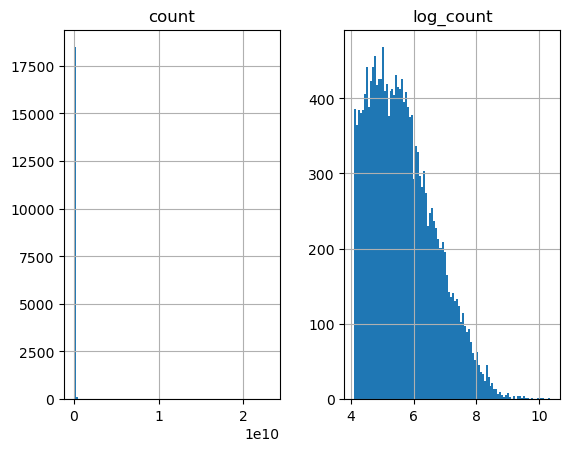

In [62]:
# Add a log value column
overlap_df["log_count"] = np.log10(overlap_df["count"])

hist_overlap = overlap_df.hist(bins=100)

In [63]:
plt.savefig(work_dir / 'fig_vocab_overlap_word_freq.pdf')

<Figure size 640x480 with 0 Axes>

In [86]:
idx_1e8 = overlap_df[overlap_df['count'] > 1e8].index
len(idx_1e8)

395

In [90]:
print(list(idx_1e8))

['the', 'of', 'and', 'to', 'in', 'for', 'is', 'on', 'that', 'by', 'this', 'with', 'it', 'not', 'or', 'be', 'are', 'from', 'at', 'as', 'all', 'have', 'new', 'more', 'an', 'can', 'about', 'if', 'page', 'my', 'has', 'search', 'free', 'but', 'one', 'other', 'no', 'information', 'time', 'site', 'he', 'up', 'their', 'out', 'any', 'only', 'so', 'his', 'contact', 'who', 'web', 'also', 'help', 'get', 'pm', 'view', 'online', 'first', 'am', 'me', 'click', 'like', 'than', 'find', 'back', 'top', 'list', 'name', 'just', 'state', 'year', 'day', 'into', 'email', 'two', 're', 'next', 'go', 'work', 'products', 'data', 'make', 'product', 'system', 'post', 'her', 'add', 'number', 'copyright', 'support', 'message', 'after', 'software', 'video', 'high', 'school', 'through', 'each', 'she', 'review', 'order', 'very', 'privacy', 'read', 'group', 'sex', 'de', 'set', 'under', 'general', 'mail', 'full', 'map', 'program', 'life', 'way', 'management', 'part', 'great', 'real', 'center', 'store', 'development', 'off'

## ___Filter corpus___

### Get docs from corpus file

- Break docs to sentences with [this post](https://stackoverflow.com/questions/46290313/how-to-break-up-document-by-sentences-with-spacy)

In [38]:
corpus = pd.read_csv(corpus_file, sep="\t", compression="gzip")
corpus.head(1)


Unnamed: 0  Index_1385417  PMID        Date                        Journal  \
0           0              3    61  1975-12-11  Biochimica et biophysica acta   

                                               Title  \
0  Identification of the 120 mus phase in the dec...   

                                            Abstract Initial filter qualifier  \
0  After a 500 mus laser flash a 120 mus phase in...                  spinach   

                                              Corpus  reg_article  \
0  Identification of the 120 mus phase in the dec...            1   

   Text classification score  \
0                   0.716394   

                                 Preprocessed corpus  Topic  
0  identification 120 mus phase decay delayed flu...     52

In [39]:
docs = corpus["Corpus"].tolist()
len(docs)

421307

In [43]:
qdocs = [] # nested list: each sublist containing qualified sentences of a doc
for doc in tqdm(docs):
  # doc to sentences
  sents = [sent for sent in nlp(doc).sents]
  for sent in sents:
    print(sent)
  break

  0%|          | 0/421307 [00:00<?, ?it/s]

Identification of the 120 mus phase in the decay of delayed fluorescence in spinach chloroplasts and subchloroplast particles as the intrinsic back reaction.
The dependence of the level of this phase on the thylakoids internal pH. After a 500 mus laser flash a 120 mus phase in the decay of delayed fluorescence is visible under a variety of circumstances in spinach chloroplasts and subchloroplast particles enriched in Photosystem II prepared by means of digitonin.
The level of this phase is high in the case of inhibition of oxygen evolution at the donor side of Photosystem II.
Comparison with the results of Babcock and Sauer (1975) Biochim.
Bio-phys.
Acta 376, 329-344, indicates that their EPR signal IIf which they suppose to be due to Z+, the oxidized first secondary donor of Photosystem II, is well correlated with a large amplitude of our 120 mus phase.
We explain our 120 mus phase by the intrinsic back reaction of the excited reaction center in the presence of Z+, as predicted by Van